### tPARAFAC2 implementation
---
The present notebook contains the synthetic data generation scheme of the paper along with the implementation of tPARAFAC2 as a constraint of Matcouply (https://github.com/MarieRoald/matcouply).

In [45]:
# Imports 

import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt
from copy import deepcopy
from random import choice
import pickle
import math
import seaborn as sns
import matcouply
from scipy import spatial
from matcouply.penalties import MatricesPenalty
from tlviz.factor_tools import degeneracy_score
from tensorly.cp_tensor import CPTensor

In [2]:
# Synthetic data generation

class data_generator():

    def __init__(self,
                 no_of_concepts,            # Number of structures existing in the data i.e. the rank.
                 type_of_drift,             # List (with length equal to no_of_concepts) that contains the type of drift for each structure.
                 type_of_change,
                 I,
                 J,
                 K,                         # Tensor dimensions, where K denotes the no of timeslices.
                 B_internal_overlap,        # Percentage that describes the overlap between the initial and final concepts in Bs.
                 B_external_overlap,        # Percentage that describes the overlap between the columns of Bs.
                 sigmoid_kurt,              # Steepness of sigmoid used in incremental drift.
                 evolution_prob,            # probabilty of a point 'evolving' in a timeslice (only applicable in incremental drift).
                 drift_indices,             # The indices that denote when concept changes in structure.
                 change_indices,            # The indices that denote when concept changes in strength.
                 noise_eta,                 # Magnitude of noise to add.
                 B_external_overlap_when    # {'start','final'} when there is full overlap between concepts.
                 ):

        self.I = I
        self.J = J
        self.K = K

        # Some very very basic error chacking
        
        if len(type_of_drift) != no_of_concepts: 
            
            raise ValueError('type_of_drift != len(no_of_concepts)')

        elif len(set(type_of_drift).difference(set(['sudden','gradual','incremental','reoccurring','incremental+reoccurring']))) != 0:

            raise ValueError('len(set(type_of_drift).difference(set(\'sudden\',\'gradual\',\'incremental\',\'reoccurring\',\'incremental+reoccuring\'))) != 0')

        elif len(drift_indices) != no_of_concepts:

            raise ValueError('len(drift_indices) != no_of_concepts')

        elif len(set(type_of_change).difference(set(['increasing','decreasing','periodical','constant']))) != 0:

            raise ValueError('len(set(type_of_change).difference(set([\'increasing\',\'decreasing\',\'periodical\',\'constant\']))) != 0:')

        else:

            self.no_of_concepts = no_of_concepts
            self.type_of_drift = type_of_drift
            self.type_of_change = type_of_change

        self.B_external_overlap = B_external_overlap
        self.B_internal_overlap = B_internal_overlap
        self.evolution_prob = evolution_prob
        self.sigmoid_kurt = sigmoid_kurt
        self.change_indices = change_indices
        self.drift_indices = drift_indices
        self.noise_eta = noise_eta
        self.B_external_overlap_when = B_external_overlap_when

    def sigmoid_(self,x,x0,kurt):
        '''
        Reutrn sigmoid f(x)=L/(1+exp(e)^(-k(x-x0)))
        '''
        return 1/(1+np.exp(-1*kurt*(x-x0)))

    def _generate_As_(self):
        '''
        Create and return A factor matrix.
        '''

        self.A_sets = []

        for pattern_no in range(self.no_of_concepts):

            self.A_sets.append(np.array([*range(pattern_no*int(self.I/self.no_of_concepts),pattern_no*int(self.I/self.no_of_concepts)+int(self.I/self.no_of_concepts))]))

        self.As = np.zeros((self.I,self.no_of_concepts))

        for pattern_no in range(self.no_of_concepts):

            for index in list(self.A_sets[pattern_no]):

                initial_val = np.random.normal(loc=0.5,scale=0.5)
                while initial_val > 1 or initial_val <= 0: initial_val = np.random.normal(loc=0.5,scale=0.5)

                self.As[index,pattern_no] = initial_val

    def _generate_Bs_(self):
        '''
        Create and return B factor matrices.
        '''

        # Generate pattern index sets

        self.B_initial_sets = []
        self.B_final_sets  = []

        for pattern_no in range(self.no_of_concepts): # For each pattern

            self.B_initial_sets.append(set())
            self.B_final_sets .append(set())

            while len(self.B_initial_sets[pattern_no]) < 3 or len(self.B_final_sets [pattern_no]) < 3 : # Need to be at least 3 words in each topic

                # Generate a rondom index between the min index of this pattern and the max and divide the indices in the initial and the final set
                diff_index = int(np.random.normal(loc=pattern_no*int(self.J/self.no_of_concepts)+(1/2)*int(self.J/self.no_of_concepts),scale=pattern_no*int(self.J/self.no_of_concepts)+(1/4)*int(self.J/self.no_of_concepts)))
                self.B_initial_sets[pattern_no] = set([*range(pattern_no*int(self.J/self.no_of_concepts),diff_index)])
                self.B_final_sets [pattern_no] = set([*range(diff_index,pattern_no*int(self.J/self.no_of_concepts)+int(self.J/self.no_of_concepts))])
                     
            # Apply internal overlap (iff applicable)

            coin_result = np.random.binomial(1,0.5) # Toss a coin

            if coin_result == 1:

                for item in self.B_initial_sets[pattern_no]:

                    if 100*len(self.B_initial_sets[pattern_no].intersection(self.B_final_sets [pattern_no]))/len(self.B_initial_sets[pattern_no]) >= self.B_internal_overlap: break

                    self.B_final_sets[pattern_no].add(item)

                for item in self.B_final_sets[pattern_no]:

                    if 100*len(self.B_initial_sets[pattern_no].intersection(self.B_final_sets [pattern_no]))/len(self.B_initial_sets[pattern_no]) >= self.B_internal_overlap: break

                    self.B_initial_sets[pattern_no].add(item)

            else:

                for item in self.B_final_sets[pattern_no]:

                    if 100*len(self.B_final_sets[pattern_no].intersection(self.B_initial_sets [pattern_no]))/len(self.B_final_sets[pattern_no]) >= self.B_internal_overlap: break

                    self.B_initial_sets[pattern_no].add(item)

                for item in self.B_initial_sets[pattern_no]:

                    if 100*len(self.B_final_sets[pattern_no].intersection(self.B_initial_sets [pattern_no]))/len(self.B_final_sets[pattern_no]) >= self.B_internal_overlap: break

                    self.B_final_sets[pattern_no].add(item)   

            # if self.type_of_drift[pattern_no] in ['sudden','gradual','reoccurring']: # In case we need the initial and final sets to be similar in size

            #     if len(self.B_initial_sets[pattern_no]) > len(self.B_final_sets [pattern_no]):

            #         while(len(self.B_initial_sets[pattern_no]) > len(self.B_final_sets [pattern_no])):

            #             item = choice(list(self.B_initial_sets[pattern_no]))

            #             if item in self.B_final_sets[pattern_no]: continue

            #             if abs(len(self.B_initial_sets[pattern_no])-len(self.B_final_sets[pattern_no])) != 1: self.B_initial_sets[pattern_no].remove(item)
            #             self.B_final_sets[pattern_no].add(item)

            #     if len(self.B_initial_sets[pattern_no]) < len(self.B_final_sets [pattern_no]):

            #         while(len(self.B_initial_sets[pattern_no]) < len(self.B_final_sets [pattern_no])):

            #             item = choice(list(self.B_final_sets[pattern_no]))

            #             if item in self.B_initial_sets[pattern_no]: continue

            #             if abs(len(self.B_initial_sets[pattern_no])-len(self.B_final_sets[pattern_no])) != 1: self.B_final_sets[pattern_no].remove(item)
            #             self.B_initial_sets[pattern_no].add(item)

            #     print(f'{pattern_no}-initial: {len(self.B_initial_sets[pattern_no])} final: {len(self.B_final_sets[pattern_no])}')

        # Apply external overlap on B (if applicable)

        if self.B_external_overlap > 0:

            # print(f'{math.ceil(self.B_external_overlap*self.J/100)} overlapping points.')

            for _ in range(math.ceil(self.B_external_overlap*self.J/100)):

                while(True):

                    concept_no = choice([*range(self.no_of_concepts)]) # choose a random concept

                    if self.B_external_overlap_when == 'start':
                        index = choice(list(self.B_initial_sets[concept_no])) # choose a random index of the initial set
                    else:
                        index = choice(list(self.B_final_sets[concept_no])) # choose a random index of the final set

                    all_concepts = [i for i in range(self.no_of_concepts)] # create a list of concepts

                    concept2remove = []

                    for concept_no2 in all_concepts:

                        if concept_no == concept_no2: concept2remove.append(concept_no2)

                        if self.B_external_overlap_when == 'start' and index in self.B_initial_sets[concept_no2] and concept_no2 not in concept2remove: concept2remove.append(concept_no2)

                        if self.B_external_overlap_when == 'final' and index in self.B_final_sets[concept_no2] and concept_no2 not in concept2remove: concept2remove.append(concept_no2)

                    if len(concept2remove) == len(all_concepts): continue

                    for val in concept2remove:
                        all_concepts.remove(val)

                    new_structure = choice(all_concepts) # choose randomly one of the other concepts

                    if self.B_external_overlap_when == 'start':
                        self.B_initial_sets[new_structure].add(index) # add the index to the other structure initial concept
                    else:
                        self.B_final_sets[new_structure].add(index) # add the index to the other structure initial concept

                    break        

        # Generate lookup tables of evolution of Bs

        self.Bs_lookup = [self.B_initial_sets]
        pattern_status = ['initial' for _ in range(self.no_of_concepts)]
        
        self.pattern_statuses = deepcopy([pattern_status])

        items2remove = [set() for i in range(self.no_of_concepts)] # Careful: may work with only one incremental pattern
        items2add = [set() for i in range(self.no_of_concepts)]

        for t in range(1,self.K):
            
            temp = deepcopy(self.Bs_lookup[-1])

            for pattern_no in range(self.no_of_concepts):

                # Sudden
                if self.type_of_drift[pattern_no] == 'sudden' and self.drift_indices[pattern_no][0] == t: 
                    temp[pattern_no] = self.B_final_sets [pattern_no]
                    pattern_status[pattern_no] = 'final'

                # Gradual
                if self.type_of_drift[pattern_no] == 'gradual' and self.drift_indices[pattern_no][0] - t >= 0:

                    if self.drift_indices[pattern_no][0] == t:
                        temp[pattern_no] = self.B_final_sets [pattern_no]
                        pattern_status[pattern_no] = 'final'

                    else:

                        coin_result = np.random.binomial(1,0.5) # Toss a coin

                        if coin_result == 1:
                            if pattern_status[pattern_no] == 'initial':
                                temp[pattern_no] = self.B_final_sets [pattern_no]
                                pattern_status[pattern_no] = 'final'
                            elif pattern_status[pattern_no] == 'final':
                                temp[pattern_no] = self.B_initial_sets[pattern_no]
                                pattern_status[pattern_no] = 'initial'                                                                

                # Incremental
                if self.type_of_drift[pattern_no] == 'incremental' and pattern_status[pattern_no] == 'initial' and t > self.drift_indices[pattern_no][0]:
                    
                    for item in temp[pattern_no]:

                        if item in items2add[pattern_no]: continue

                        # change_prob = self.sigmoid_(t,self.drift_indices[pattern_no][0])

                        coin_result = np.random.binomial(1,self.evolution_prob)

                        if coin_result == 1:

                            opt_menu = [0,1,2] # 0: Remove item from temp, 1: add item from final, 2: exchange

                            if self.B_final_sets [pattern_no].intersection(temp[pattern_no]) == self.B_final_sets [pattern_no]:
                                opt_menu.remove(1)

                            if item in self.B_final_sets [pattern_no]:
                                opt_menu.remove(0)

                            if item in self.B_final_sets [pattern_no] or self.B_final_sets [pattern_no].intersection(temp[pattern_no]) == self.B_final_sets [pattern_no]:
                                opt_menu.remove(2)

                            if len(opt_menu) == 0: continue

                            option = choice(opt_menu)

                            if option == 0: # Remove item from temp

                                items2remove[pattern_no].add(item)

                            elif option == 1: # Add random item from final 

                                new_index = choice(list(self.B_final_sets [pattern_no].difference(temp[pattern_no])))
                                items2add[pattern_no].add(new_index)   
             
                            elif option == 2: # exhcange
                                
                                new_index = choice(list(self.B_final_sets [pattern_no].difference(temp[pattern_no])))
                                items2remove[pattern_no].add(item)
                                items2add[pattern_no].add(new_index)

                    temp[pattern_no].difference_update(items2remove[pattern_no])
                    temp[pattern_no].update(items2add[pattern_no])

                    if self.B_final_sets [pattern_no] == temp[pattern_no]:
                                
                        pattern_status[pattern_no] = 'final'

                # Reoccuring
                if self.type_of_drift[pattern_no] == 'reoccurring' and t % self.drift_indices[pattern_no][0] == 0:
                    if pattern_status[pattern_no] == 'initial':

                        temp[pattern_no] = self.B_final_sets[pattern_no]
                        pattern_status[pattern_no] = 'final'

                    else:

                        temp[pattern_no] = self.B_initial_sets[pattern_no]
                        pattern_status[pattern_no] = 'initial'


            self.Bs_lookup.append(temp)
            self.pattern_statuses.append(deepcopy(pattern_status))

        # Create Bs according to the index matrices

        self.Bs = []

        factor_template = np.zeros((self.J,self.no_of_concepts))

        missing_indices = [[] for u in range(self.no_of_concepts)]
        missing_indices_timestamps = [[] for u in range(self.no_of_concepts)]

        new_indices = [[] for u in range(self.no_of_concepts)]
        new_indices_timestamps = [[] for u in range(self.no_of_concepts)]

        pattern_norms = {}

        for t in range(self.K):

            self.Bs.append(deepcopy(factor_template))

            for pattern_no in range(self.no_of_concepts):

                for index in self.Bs_lookup[t][pattern_no]:

                    ## Randomly chosen values - uncomment following lines

                    val = np.random.uniform(0.5, 1.0)
                    while val < 0.5: val = np.random.uniform(0.5, 1.0)

                    self.Bs[t][index,pattern_no] = val

                    ## Bks that follow the PARAFAC2 constraint - uncomment following lines

                # if t == 0:

                #     n = len(self.Bs_lookup[t][pattern_no])
                #     numbers = []

                #     # Generate n random numbers between 0.5 and 1.0
                #     for i in range(n):
                #         numbers.append(np.random.uniform(0.5, 1.0))

                #     pattern_norms[pattern_no] = np.sqrt(np.sum([num**2 for num in numbers]))
                #     # print(f'be pattern{pattern_no}_norm:{pattern_norms[pattern_no]}')

                #     for index in self.Bs_lookup[t][pattern_no]:
                #         self.Bs[t][index,pattern_no] = numbers.pop()

                # else:

                #     n = len(self.Bs_lookup[t][pattern_no])
                #     numbers = []

                #     # Generate n random numbers between 0.5 and 1.0
                #     for i in range(n):
                #         numbers.append(np.random.uniform(0.5, 1.0))

                #     my_norm = np.sqrt(np.sum([n**2 for n in numbers]))
                #     numbers = [num*(pattern_norms[pattern_no]/my_norm) for num in numbers]
                #     # print(f'aft my_norm:{np.sqrt(np.sum([n**2 for n in numbers]))}')

                #     for index in self.Bs_lookup[t][pattern_no]:

                #         self.Bs[t][index,pattern_no] = numbers.pop()

                if self.type_of_drift[pattern_no] == 'incremental' and t > 0:

                    # Find missing indices

                    missing_indices[pattern_no].extend(list(self.Bs_lookup[t-1][pattern_no].difference(self.Bs_lookup[t][pattern_no])))
                    missing_indices_timestamps[pattern_no].extend([t for _ in range(len(self.Bs_lookup[t-1][pattern_no].difference(self.Bs_lookup[t][pattern_no])))])

                    # find new indices

                    new_indices[pattern_no].extend(list(self.Bs_lookup[t][pattern_no].difference(self.Bs_lookup[t-1][pattern_no])))
                    new_indices_timestamps[pattern_no].extend([t for _ in range(len(self.Bs_lookup[t][pattern_no].difference(self.Bs_lookup[t-1][pattern_no])))])

                    # Apply sigmoid to missing indices

                    for i in range(len(missing_indices[pattern_no])):

                        self.Bs[t][missing_indices[pattern_no][i],pattern_no] = self.Bs[missing_indices_timestamps[pattern_no][i]-1][missing_indices[pattern_no][i],pattern_no] * self.sigmoid_(t,missing_indices_timestamps[pattern_no][i],-1*self.sigmoid_kurt)

                    # Apply sigmoid to new indices

                    for i in range(len(new_indices[pattern_no])):

                        self.Bs[t][new_indices[pattern_no][i],pattern_no] *= self.sigmoid_(t-2,new_indices_timestamps[pattern_no][i],self.sigmoid_kurt)

    def _generate_Cs_(self):
        '''
        Create and return C factor matrices.
        '''

        self.Cs = [deepcopy(np.eye(self.no_of_concepts))]

        for concept_no in range(self.no_of_concepts):

            init_val = choice([*range(5,20)])

            self.Cs[0][concept_no,concept_no] *= init_val 

        for concept_no in range(self.no_of_concepts):
            
            if self.type_of_change[concept_no] == 'increasing':
                self.Cs[0][concept_no,concept_no] = 0

        change = []

        for t in range(1,self.K):

            self.Cs.append(deepcopy(self.Cs[-1]))

            for pattern_no in range(self.no_of_concepts):

                if self.type_of_change[pattern_no] == 'increasing' and self.change_indices[pattern_no][0] <= t:

                    change = np.random.normal(loc=1.5,scale=0.5)
                    while(change < 0): change = np.random.normal(loc=1.5,scale=0.5)

                    self.Cs[t][pattern_no,pattern_no] += change

                elif self.type_of_change[pattern_no] == 'decreasing' and self.change_indices[pattern_no][0] <= t:

                    change = np.random.normal(loc=1.5,scale=0.5)
                    while(change < 0): change = np.random.normal(loc=1.5,scale=0.5)

                    self.Cs[t][pattern_no,pattern_no] -= change
                
                elif self.type_of_change[pattern_no] == 'periodical':

                    if math.ceil(t/self.change_indices[pattern_no][0]) % 2 == 0:

                        change = np.random.normal(loc=2.5,scale=0.5)
                        while(change < 0): change = np.random.normal(loc=2.5,scale=0.5)

                        self.Cs[t][pattern_no,pattern_no] += change

                    else:

                        change = np.random.normal(loc=2.5,scale=0.5)
                        while(change < 0): change = np.random.normal(loc=2.5,scale=0.5)

                        self.Cs[t][pattern_no,pattern_no] -= change

                elif self.type_of_change[pattern_no] == 'constant':

                    change = np.random.normal(loc=0,scale=0.25)

                    self.Cs[t][pattern_no,pattern_no] += change

                self.Cs[t][np.where(np.diag(self.Cs[t]) <= 0)[0],np.where(np.diag(self.Cs[t]) <= 0)[0]] = 0.01 # Set non-positive values as 0.01!

    def _add_noise_(self):
        '''
        Add noise to generated tensor.
        '''

        new_data = self.data

        noisy_tensor = np.random.normal(loc=0,scale=1,size=new_data.shape)
        noisy_tensor = self.noise_eta * tl.norm(self.data) * (noisy_tensor / tl.norm(noisy_tensor))
        
        self.data = new_data + noisy_tensor

    def generate_data(self):
        '''
        Returns the generated data with given parameters.
        '''

        if not hasattr(self,'data'):

            # Generate factor matrices

            self._generate_As_()

            self._generate_Bs_()

            self._generate_Cs_()

            # Form tensor

            X = tl.zeros((self.I,self.J,self.K))

            for t in range(self.K):

                X[...,t] = self.As @ self.Cs[t] @ self.Bs[t].T

            self.data=X

            # Add random noise

            self._add_noise_()

            return X
        
        else:

            if self.noise_std != 0.0: self._add_noise_()

            return self.data

    def plot_As(self):

        fig, axes = plt.subplots(1,1,figsize=(5,5))

        im = axes.imshow(self.As)

        axes.set_xticks([])
        axes.set_yticks([])

        fig.colorbar(im,ax=axes,pad=0.02)

    def plot_Bs(self):     

        fig, axes = plt.subplots(1,self.no_of_concepts)
        plt.tight_layout()

        for i in range(self.no_of_concepts):

            B_2_plot_gnd_truth = form_plotting_B(self.Bs,i,self.J,self.K)
            im = sns.heatmap(B_2_plot_gnd_truth.T,ax=axes[i],cbar = False,cmap='viridis',rasterized=True)
            axes[i].tick_params(left=False, bottom=True)
            axes[i].patch.set_edgecolor('black')
            axes[i].set_yticks([])
            axes[i].patch.set_linewidth(1.5)
            axes[i].set_xticks([4,9,14,19],labels=[5,10,15,20],fontsize=3.5)
            axes[i].set_xlabel(r'time',fontsize=6)
            axes[i].set_ylabel(r'words',fontsize=6)
            axes[i].set_yticks([])
            axes[i].set_title(f'{self.type_of_drift[i]}',pad=3.5,fontsize=6)
    
    def plot_Cs(self):

        fig, axes = plt.subplots(1,1)

        C_tensor = self.get_C_matrix()

        axes.set_title(label='Columns of $C$',pad=3.5,fontsize=6)
        axes.set_xticks([*range(1,self.K+1)])
        axes.set_xlabel('time',fontsize=6)
        axes.set_ylabel('strength',fontsize=6)

        styles = ['solid','dotted','dashed','dashdot']
        
        for pattern_no in range(self.no_of_concepts):

            axes.plot([*range(self.K)],C_tensor[:,pattern_no],label=f'$c_{pattern_no}$:{self.type_of_change[pattern_no]}',linewidth=0.5,linestyle=styles[pattern_no])
        
        axes.set_xticks([])
        axes.set_xticklabels([])
        axes.set_xticks([*range(0,self.K,2)])
        axes.set_yticks([0,10,20])
        axes.set_xticklabels([*range(1,self.K+1,2)],fontsize=3.5)

        axes.legend(fontsize=4.5)
        plt.show()

    def dump_data(self,filename):
        '''
        Dump generator into files with pickle for easy readability.
        '''

        with open(filename, 'wb') as outp:
            pickle.dump(self,outp,pickle.HIGHEST_PROTOCOL)

    def get_C_matrix(self):

        new_Cs = tl.zeros((self.K,self.no_of_concepts))

        for t in range(self.K):

            new_Cs[t,:] = np.diag(self.Cs[t])

        return new_Cs

    def normalize_As(self):
        '''
        Column normalize each component.
        '''

        new_As = deepcopy(self.As)

        for a_col in range(self.no_of_concepts):

                new_As[:,a_col] /= np.linalg.norm(new_As[:,a_col])

        return new_As

    def normalize_Bs(self):
        '''
        Column normalize each component.
        '''

        new_Bs = deepcopy(self.Bs)

        for r in range(self.no_of_concepts):

            b_temp = new_Bs[0][:,r]

            for k in range(1,len(new_Bs)):

                b_temp = np.concatenate((b_temp,new_Bs[k][:,r]))

            for k in range(len(new_Bs)):

                new_Bs[k][:,r] = new_Bs[k][:,r] / np.linalg.norm(b_temp)

        return new_Bs

    def normalize_Cs(self,return_one_matrix=False):
        '''
        Column normalize each component.
        '''

        if return_one_matrix == False:

            new_Cs = deepcopy(self.Cs)

            for pattern_no in range(self.no_of_concepts):

                # Find norm of column of vector

                c_vec = np.array([new_Cs[0][pattern_no,pattern_no]])

                for t in range(self.K):

                    c_vec = np.append(c_vec,new_Cs[t][pattern_no,pattern_no])

                c_norm = np.linalg.norm(c_vec)

                # Divide each entry by the norm

                for t in range(self.K):

                    new_Cs[t][pattern_no,pattern_no] = new_Cs[t][pattern_no,pattern_no] / c_norm

        else:

            new_Cs = tl.zeros((self.K,self.no_of_concepts))

            for t in range(self.K):

                new_Cs[t,:] = np.diag(self.Cs[t]) / tl.norm(np.diag(self.Cs[t]))

        return new_Cs

def form_plotting_B(B_list,pattern_no,J,K):
    '''
    Takes as input a list of B factors and return a matrix containing 
    the pattern_no-th column of each factor matrix.
    '''

    matrix2return = np.zeros((K,J))

    for k in range(K):

        matrix2return[k,:] = B_list[k][:,pattern_no].T

    return matrix2return

In [3]:
# Matcouply custom penalty class

class TemporalSmoothnessPenalty(MatricesPenalty):
    def __init__(self, smoothness_l, aux_init="random_uniform", dual_init="random_uniform"):
        super().__init__(aux_init=aux_init, dual_init=dual_init)
        self.smoothness_l = smoothness_l

    @copy_ancestor_docstring
    def factor_matrices_update(self, factor_matrices, feasibility_penalties, auxes):
        
        # factor_matrices: factor + mus
        # feasability_penalties: rhos
        # auxes: -||-

        B_is = factor_matrices
        rhos = feasibility_penalties

        rhs = [rhos[i] * factor_matrices[i] for i in range(len(B_is))]

        # Construct matrix A to peform gaussian elimination on

        A = np.zeros((len(B_is),len(B_is)))

        for i in range(len(B_is)):
            for j in range(len(B_is)):
                if i == j: A[i,j] = 4*self.smoothness_l + rhos[i]
                elif i == j-1 or i == j+1: A[i,j] = -2*self.smoothness_l
                else:
                    pass

        A[0,0] -= 2*self.smoothness_l
        A[len(B_is)-1,len(B_is)-1] -= 2*self.smoothness_l

        # Peform GE

        for k in range(1,A.shape[-1]):
            m = A[k,k-1]/A[k-1,k-1]

            A[k,:] = A[k,:] - m * A[k-1,:]
            rhs[k] = rhs[k] - m * rhs[k-1] # Also update the respective rhs!

        # Back-substitution

        new_ZBks = [np.empty_like(B_is[i]) for i in range(len(B_is))]

        new_ZBks[-1] = rhs[-1]/A[-1,-1]
        q = new_ZBks[-1]

        for i in range(A.shape[-1]-2,-1,-1):
            q = (rhs[i] - A[i,i+1] * q) / A[i,i]
            new_ZBks[i] = q 

        return new_ZBks

    def penalty(self, x):
        penalty = 0
        for x1, x2 in zip(x[:-1], x[1:]):
            penalty += np.sum((x1-x2)**2)   
        return self.smoothness_l * penalty

In [35]:
# Plotting functions


def get_plot_mask(gnd_B,est_B,gnd_A,est_A):
    '''
    Returns a matrix that matches each column vector
    to components of the ground truth.
    '''

    decomp_rank = est_B[0].shape[1]

    # Create masking matrix
    plot_mask = [-1 for u in range(decomp_rank)]

    for factor_no in range(decomp_rank):

        cur_b_factor = form_plotting_B(np.absolute(est_B),factor_no,est_B[0].shape[0],len(est_B))
        cur_b_gnd_factor = form_plotting_B(gnd_B,0,est_B[0].shape[0],len(est_B))

        best_match = 0
        best_dist = spatial.distance.cosine(np.absolute(cur_b_factor.flatten()),cur_b_gnd_factor.flatten()) + spatial.distance.cosine(np.absolute(est_A[:,factor_no]),gnd_A[:,0])

        for i in range(1,decomp_rank):

            cur_b_gnd_factor = form_plotting_B(gnd_B,i,est_B[0].shape[0],len(est_B))

            if spatial.distance.cosine(np.absolute(cur_b_factor.flatten()),cur_b_gnd_factor.flatten()) + spatial.distance.cosine(np.absolute(est_A[:,factor_no]),gnd_A[:,i]) <= best_dist:

                best_match = i
                best_dist = spatial.distance.cosine(np.absolute(cur_b_factor.flatten()),cur_b_gnd_factor.flatten()) + spatial.distance.cosine(np.absolute(est_A[:,factor_no]),gnd_A[:,i])

        plot_mask[factor_no] = best_match

    return plot_mask

def plot_Bs(data_generator,factor_list):
    '''
    Plot groudn truth and A and D factors alongside each other.
    titles contains a list of titles per column

    If any of the above are not given, plot what is available each time.
    '''

    fig, axes = plt.subplots(data_generator.no_of_concepts,1+len(factor_list),figsize=(12,6))
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)

    # Normalize ground truth factors
    gnd_Bs = data_generator.normalize_Bs()
    gnd_A = data_generator.normalize_As()

    B_2_plot_gnd_truth = []

    for pattern_no in range(data_generator.no_of_concepts):

        # Create ground truth matrix

        B_2_plot_gnd_truth.append(form_plotting_B(gnd_Bs,pattern_no,data_generator.J,data_generator.K))

        im = axes[pattern_no][0].imshow(B_2_plot_gnd_truth[-1],vmin=-0.4,vmax=1.0,cmap='viridis')
        axes[pattern_no][0].set_xticks([])
        axes[pattern_no][0].set_yticks([])
        axes[pattern_no][0].yaxis.set_label_position("left")
        axes[pattern_no][0].set_ylabel(f'Pattern {pattern_no}')
        if pattern_no == 0: axes[pattern_no][0].set_title('Ground truth')

    if len(factor_list) >= 1: # More factors are given as input

        for l in range(len(factor_list)):

            est_A = factor_list[l][2]
            est_B = factor_list[l][1]
            est_D = factor_list[l][0]

            for r in range(data_generator.no_of_concepts):

                est_A[:,r] = est_A[:,r] / tl.norm(est_A[:,r])

                b_temp = est_B[0][:,r]

                for k in range(1,len(gnd_Bs)):

                    b_temp = np.concatenate((b_temp,est_B[k][:,r]))

                for k in range(len(gnd_Bs)):

                    est_B[k][:,r] = est_B[k][:,r] / np.linalg.norm(b_temp)

            plot_mask = get_plot_mask(gnd_Bs,est_B,gnd_A,est_A)

            for pattern_no in range(data_generator.no_of_concepts):

                parafac2_estimate_B = form_plotting_B(est_B,pattern_no,data_generator.J,data_generator.K)

                im = axes[plot_mask[pattern_no]][l+1].imshow(parafac2_estimate_B,vmin=-0.4,vmax=0.4,cmap='viridis')
                axes[plot_mask[pattern_no]][l+1].set_xticks([])
                axes[plot_mask[pattern_no]][l+1].set_yticks([])

def plot_A(data_generator,factor_list):
    '''
    Plot groudn truth and A factors alongside each other.
    factor_list is a list containing factors in this specific order:
    titles contains a list of titles per column

    If any of the above are not given, plot what is available each time.
    '''

    fig, axes = plt.subplots(data_generator.no_of_concepts,len(factor_list),figsize=(12,6))

    # Normalize ground truth factors

    gnd_A = data_generator.normalize_As()
    gnd_Bs = data_generator.normalize_Bs()

    # Iterate over given factors

    for l in range(len(factor_list)):

        est_A = factor_list[l][2]
        est_B = factor_list[l][1]

        for r in range(data_generator.no_of_concepts):

            est_A[:,r] = est_A[:,r] / tl.norm(est_A[:,r])

            b_temp = est_B[0][:,r]

            for k in range(1,len(gnd_Bs)):

                b_temp = np.concatenate((b_temp,est_B[k][:,r]))

            for k in range(len(gnd_Bs)):

                est_B[k][:,r] = est_B[k][:,r] / np.linalg.norm(b_temp)

        plot_mask = get_plot_mask(gnd_Bs,est_B,gnd_A,est_A)

        for pattern_no in range(data_generator.no_of_concepts):

            # Plot ground truth (gnd_A)

            try: # This is a hack for the case we want to plot just one set of factors

                im = axes[pattern_no][l].plot(gnd_A[:,pattern_no],label='gnd truth',color='tab:blue',alpha=0.4)

                # Plot factor (est_A)
                axes[plot_mask[pattern_no]][l].plot(est_A[:,pattern_no],label='factor',color='tab:blue')

                # Add plotting settings
                if l == len(factor_list)-1 and pattern_no == data_generator.no_of_concepts-1: 
                    axes[pattern_no][l].legend(prop={'size': 7})
                axes[pattern_no][l].set_ylabel(f'Pattern {pattern_no}')
                axes[pattern_no][l].set_xticks([])

            except:
                
                im = axes[pattern_no].plot(gnd_A[:,pattern_no],label='gnd truth',color='tab:blue',alpha=0.4)

                # Plot factor (est_A)
                axes[plot_mask[pattern_no]].plot(est_A[:,pattern_no],label='factor',color='tab:blue')

                # Add plotting settings
                if l == len(factor_list)-1 and pattern_no == data_generator.no_of_concepts-1: 
                    axes[pattern_no].legend(prop={'size': 7})
                axes[pattern_no][l].set_ylabel(f'Pattern {pattern_no}')
                axes[pattern_no].set_xticks([])

def plot_C(data_generator,factor_list):
    '''
    Plot groudn truth and A factors alongside each other.
    factor_list is a list containing factors in this specific order:
    titles contains a list of titles per column

    If any of the above are not given, plot what is available each time.
    '''
    # Determine size of plot

    fig, axes = plt.subplots(data_generator.no_of_concepts,len(factor_list),figsize=(12,6))

    # Normalize ground truth factors

    gnd_A = data_generator.normalize_As()
    gnd_Bs = data_generator.normalize_Bs()
    gnd_Cs = data_generator.normalize_Cs(return_one_matrix=True)

    # Iterate over given factors

    for l in range(len(factor_list)):

        est_A = factor_list[l][2]
        est_B = factor_list[l][1]
        est_C = factor_list[l][0]

        for r in range(data_generator.no_of_concepts):

            est_A[:,r] = est_A[:,r] / tl.norm(est_A[:,r])

            b_temp = est_B[0][:,r]

            for k in range(1,len(gnd_Bs)):

                b_temp = np.concatenate((b_temp,est_B[k][:,r]))

            for k in range(len(gnd_Bs)):

                est_C[k,:] = est_C[k,:] / tl.norm(est_C[k,:])

                est_B[k][:,r] = est_B[k][:,r] / np.linalg.norm(b_temp)

        plot_mask = get_plot_mask(gnd_Bs,est_B,gnd_A,est_A)

        for pattern_no in range(data_generator.no_of_concepts):

            try:

                # Plot ground truth (gnd_A)
                im = axes[pattern_no][l].plot(gnd_Cs[:,pattern_no],label='gnd truth',color='tab:green',alpha=0.4)

                # Plot factor (est_A)
                axes[plot_mask[pattern_no]][l].plot(est_C[:,pattern_no],label='factor',color='tab:green')

                # Add plotting settings
                if l == len(factor_list)-1 and pattern_no == data_generator.no_of_concepts-1: 
                    axes[pattern_no][l].legend(prop={'size': 7})
                axes[pattern_no][l].set_ylabel(f'Pattern {pattern_no}')
                axes[pattern_no][l].set_xticks([])
                
            except:

                # Plot ground truth (gnd_A)
                im = axes[pattern_no].plot(gnd_Cs[:,pattern_no],label='gnd truth',color='tab:green',alpha=0.4)

                # Plot factor (est_A)
                axes[plot_mask[pattern_no]].plot(est_C[:,pattern_no],label='factor',color='tab:green')
                # Add plotting settings
                if l == len(factor_list)-1 and pattern_no == data_generator.no_of_concepts-1: 
                    axes[pattern_no].legend(prop={'size': 7})
                axes[pattern_no].set_ylabel(f'Pattern {pattern_no}')
                axes[pattern_no].set_xticks([])

def plot_results(data_generator,factor_list):
    '''
    Plots results of given factors along with the
    ground truth. Takes care of component matching.
    '''

    # Plot Bs
    plot_Bs(data_generator,factor_list)

    # Plot As
    plot_A(data_generator,factor_list)

    # Plot Cs
    plot_C(data_generator,factor_list)

In [50]:
def check_degenerate(factors,threshold=-0.85):
    '''
    Check solution for degenerecy (just a wrapper for tlviz degeneracy score).
    '''

    A = factors[0]
    B = factors[1]
    D = factors[2]

    new_B = np.zeros((len(B)*B[0].shape[0],B[0].shape[-1]))

    for r in range(B[0].shape[-1]):
        
        b_temp = B[0][:,r]

        for k in range(1,len(B)):

            b_temp = np.concatenate((b_temp,B[k][:,r]))

        new_B[:,r] = b_temp

    decomp = CPTensor((np.array([1.0,1.0,1.0,1.0]),(A,new_B,D)))

    if degeneracy_score(decomp) < threshold: return True
    else: return False

### Example usage

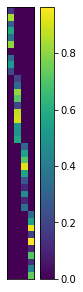

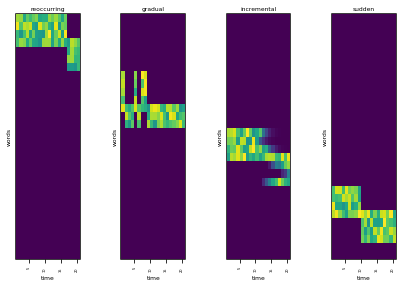

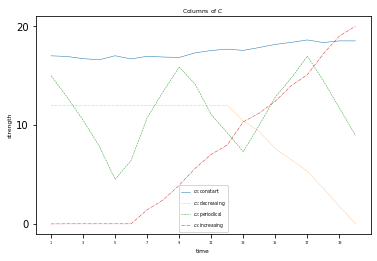

In [53]:
# 1. Create some synthetic data with desired properties

c1 = np.random.randint(low=2,high=18)
c2 = np.random.randint(low=2,high=18)
c3 = np.random.randint(low=2,high=18)
c4 = np.random.randint(low=2,high=18)

my_generator = data_generator(no_of_concepts=4,
type_of_drift=['reoccurring','gradual','incremental','sudden'],
type_of_change = ['constant','decreasing','periodical','increasing'],
I=40,
J=30,
K=20,
B_internal_overlap=25,
B_external_overlap=0,
sigmoid_kurt=1,
evolution_prob=0.3,
drift_indices=[[c1],[c2],[c3],[c3]],
change_indices=[[4],[12],[4],[6]],
noise_eta=0.25,
B_external_overlap_when='start'
)

data = my_generator.generate_data()
my_generator.plot_As()
my_generator.plot_Bs()
my_generator.plot_Cs()

In [54]:
# 2. Run multiple initialization of tPARAFAC2

from matcouply.penalties import NonNegativity,Parafac2
import matcouply.decomposition as decomposition

no_of_inits = 20
n_iter_max = 1000

factors_per_init = []
diagnostics_per_init = []

for init in range(no_of_inits):

    regs = [[NonNegativity()],
        [Parafac2(), TemporalSmoothnessPenalty(smoothness_l=10)],
        []]

    (weights,(D,B,A)),diagnostics = decomposition.cmf_aoadmm(
        matrices=[tl.tensor(data[:,:,u].T) for u in range(data.shape[-1])],
        rank=4,
        return_errors = True,
        n_iter_max=n_iter_max,
        l2_penalty=[2*10e-2,0,2*10e-2],
        regs=regs,
        verbose=0,
        tol=1e-3,
        inner_n_iter_max=20,
        absolute_tol=1e-3,
        feasibility_tol=1e-4,
        inner_tol=1e-4,
    )

    factors_per_init.append([D,B,A])
    diagnostics_per_init.append(diagnostics)

In [55]:
# 3. Find best performing run (least loss)

least_loss = np.Inf
least_loss_run = -1

for i in range(len(factors_per_init)):

    if diagnostics_per_init[i].regularized_loss[-1] < least_loss and diagnostics_per_init[i].n_iter < 1000 and check_degenerate(factors_per_init[i]) == False:

        least_loss_run = i
        least_loss = diagnostics_per_init[i].regularized_loss[-1]

# Print feasibility gap to make sure it satisfies the requirements

print(diagnostics_per_init[least_loss_run].feasibility_gaps[-1])

([0.0], [2.1120760399510283e-05, 2.4021256936184766e-07], [])


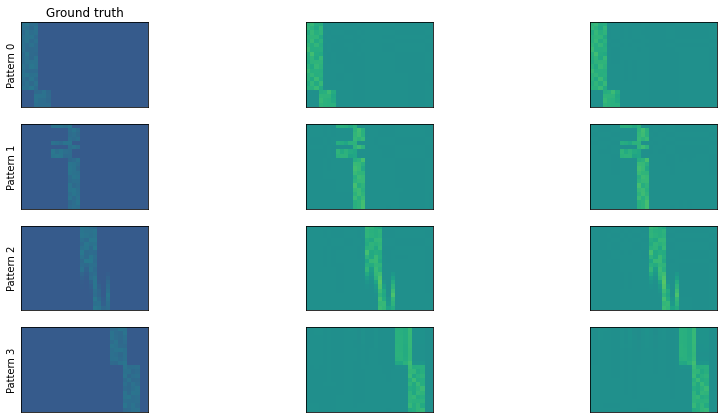

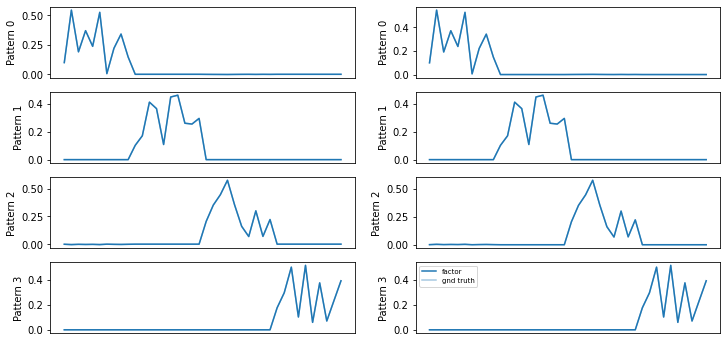

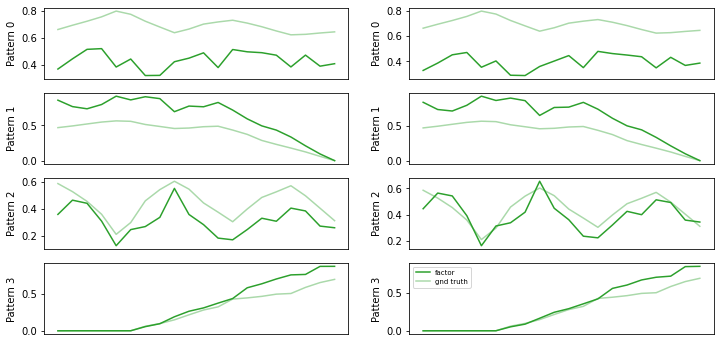

In [56]:
# 4. Plot factors

plot_results(my_generator,factor_list=[factors_per_init[least_loss_run],factors_per_init[least_loss_run-1]])